In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
# from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from lehd import OriginDestinationEmploymentDataProvider

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from shapely.geometry import Point

import statistics
import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [3]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

## Plot income-level f(d) curves

In [4]:
import json

f = open('Distfd1.json')
Distfd1 = json.load(f)

f = open('Distfd3.json')
Distfd3 = json.load(f)

citiesList = ['New York City','Los Angeles','Chicago','Houston',
          'Boston','Phoenix','Philadelphia','San Antonio','San Diego', 'Dallas', 'San Jose', 'Austin']
points = [0.480595,1.118437,1.02187,1.809567,1.662374,1.837157,0.731242,2.082544,1.99236, 1.540729, 1.480432, 2.497922]
startPoints = dict(zip(citiesList, points))

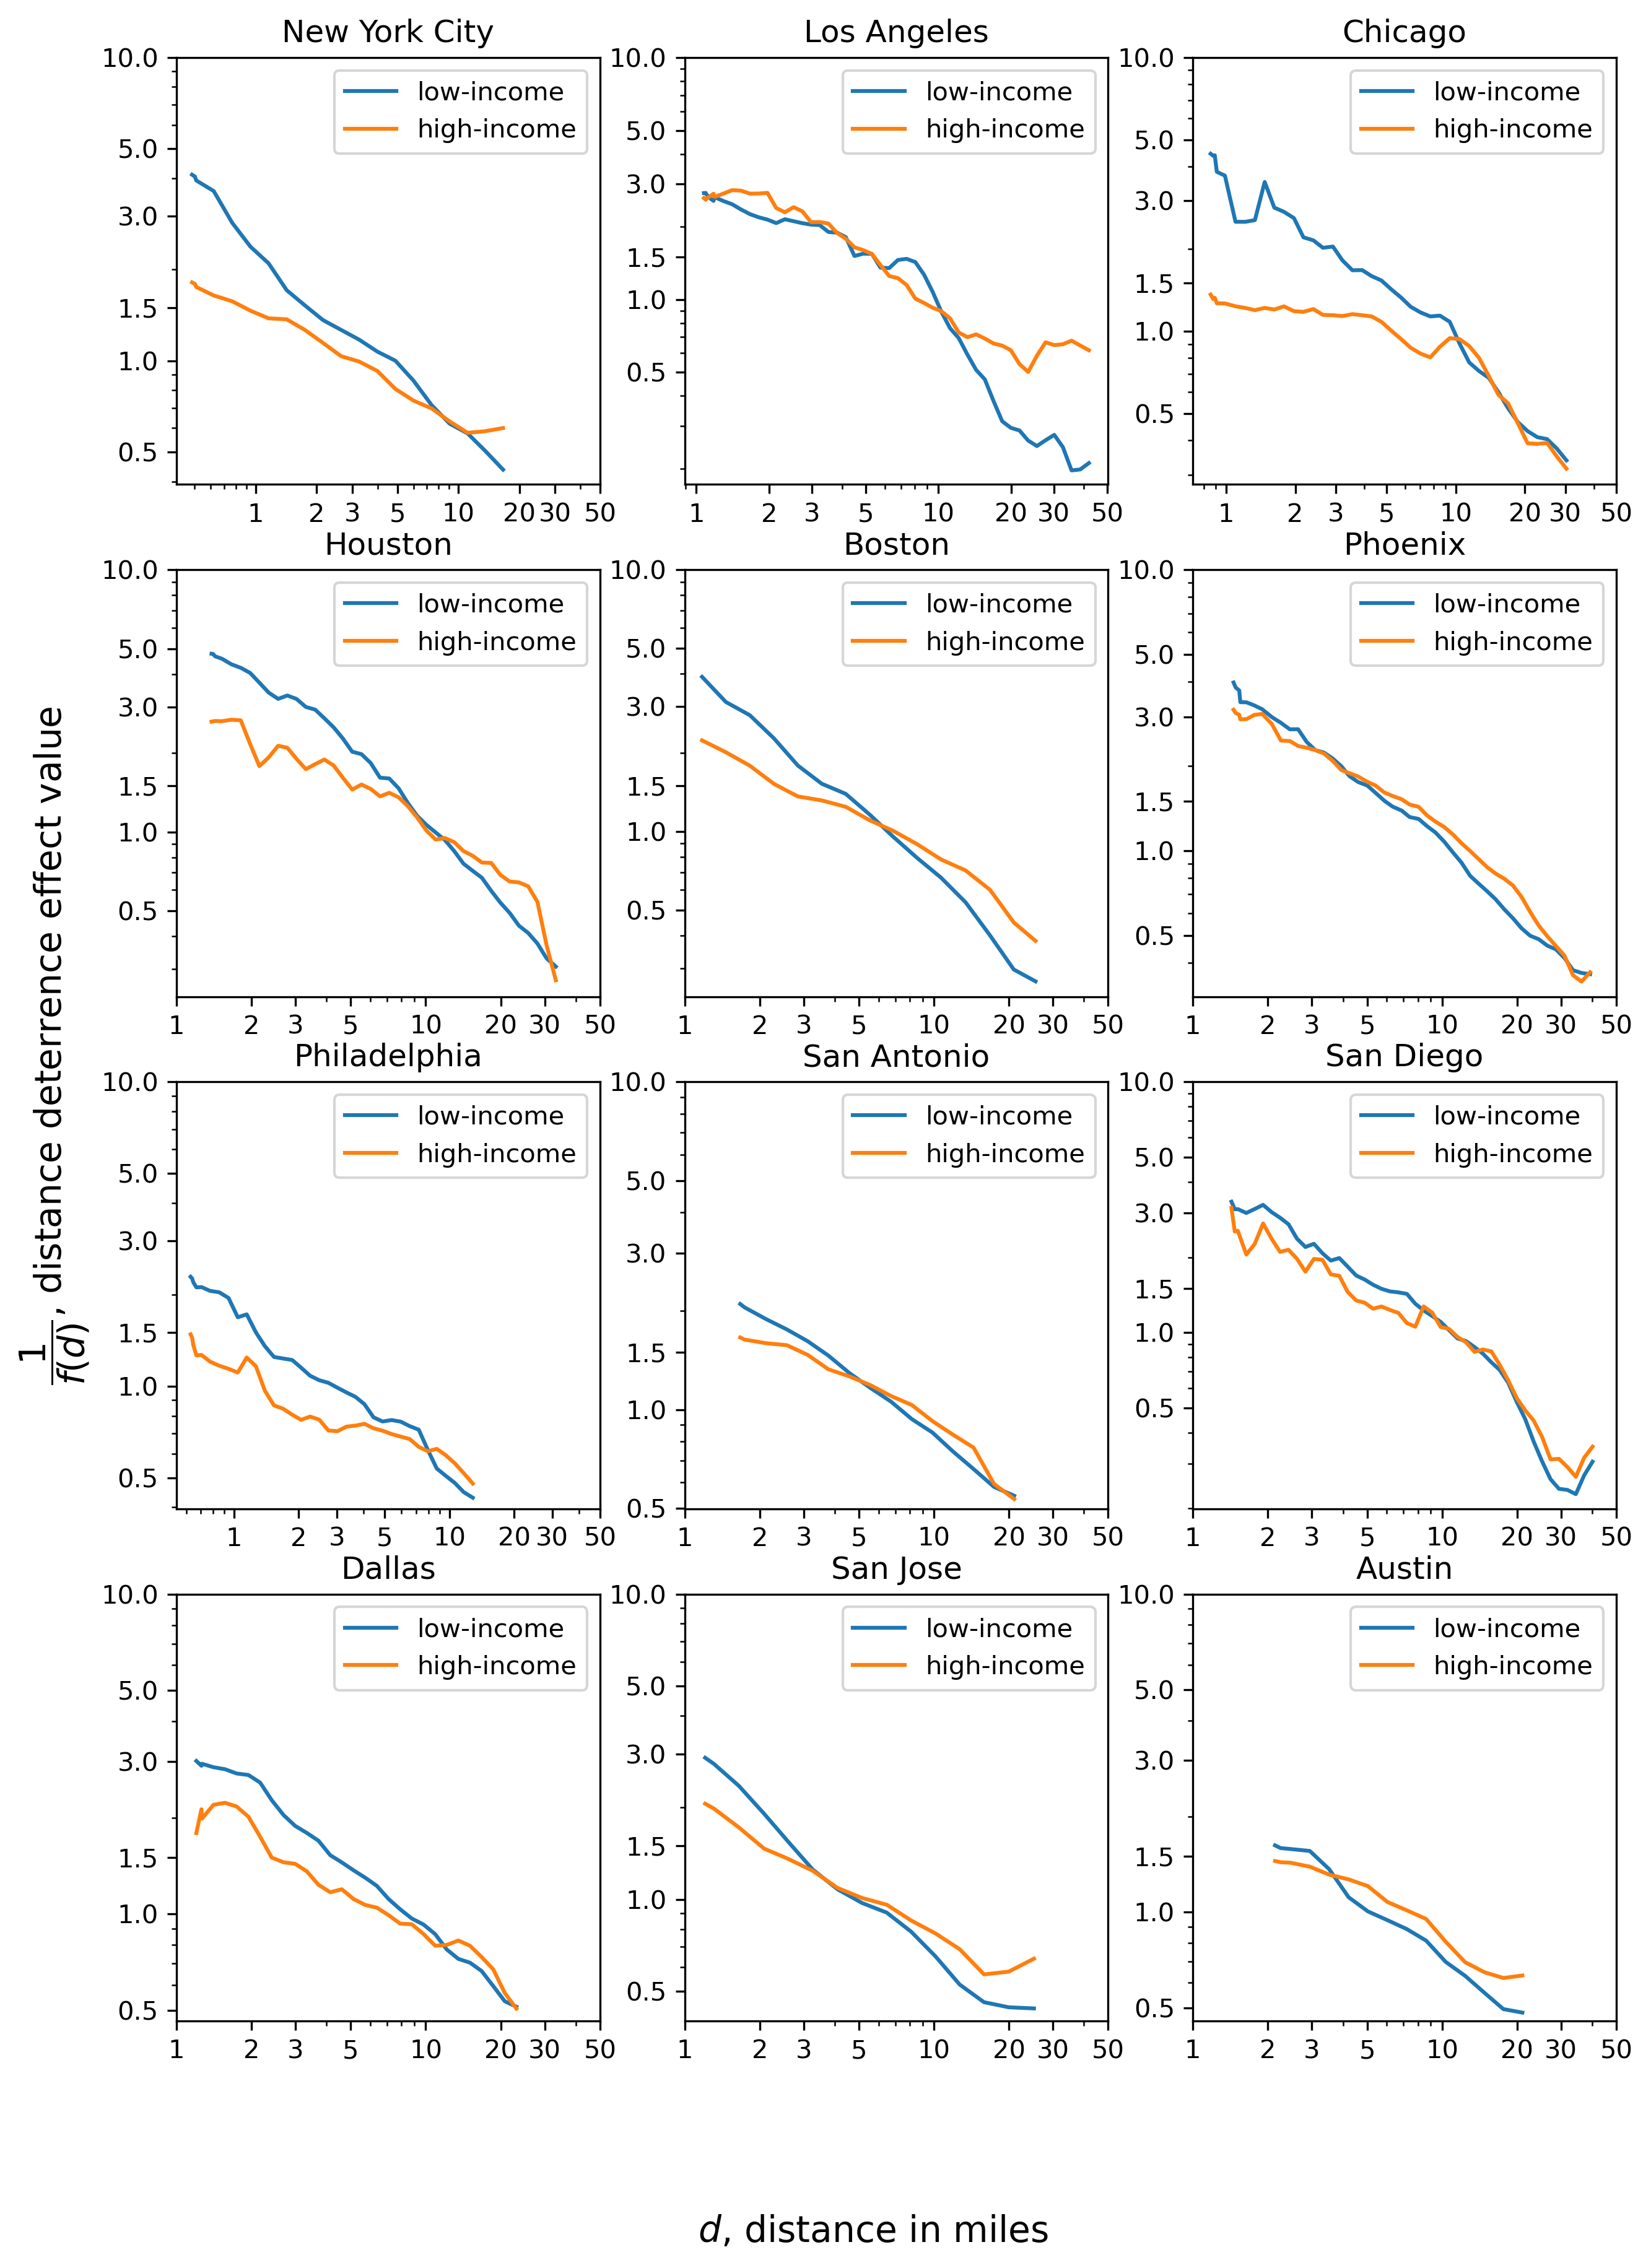

In [6]:
fig,ax = plt.subplots(4,3,figsize=(10,14),dpi=300)
i= 0
for city,state, counties in cities:
    if city in citiesList:
        ax[i//3,i%3].plot([float(i) for i in Distfd1[city].keys()],Distfd1[city].values(),label='low-income')
        ax[i//3,i%3].plot([float(i) for i in Distfd3[city].keys()],Distfd3[city].values(),label='high-income')
        ax[i//3,i%3].set_title(city)
        ax[i//3,i%3].legend()
        ax[i//3,i%3].set_yscale('log')
        ax[i//3,i%3].set_xscale('log')
        ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
        ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
        ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#         ax[i//3,i%3].set_ylabel('$f(d)$, distance deterrence effect value',fontsize=12)
#         ax[i//3,i%3].set_xlabel('$d$, distance in miles',fontsize=12)
        i += 1
        
fig.text(0.5, 0.04, '$d$, distance in miles',fontsize=14, ha='center')
fig.text(0.04, 0.5, r'$\dfrac{1}{f(d)}$, distance deterrence effect value',fontsize=14, va='center', rotation='vertical')

plt.savefig('img/curve.png',dpi=300)

### privilege zone

https://data.census.gov/cedsci/table?q=means%20of%20commute&g=0500000US36061&tid=ACSST5Y2018.S0802

LA 281544/4931598
Chicago 496282/2552596
Houston 55548/2263632
Boston (110172+114242)/(893202+458072)
Phoenix 42488/2166639
Philadelphia 181698/711264
San Antonio 181698/711264
San Diego 47478/1671791
Dallas 32191/1308392
San Jose 47636/995301
Austin 18617/719100

In [11]:
## percentage of commuters taking public transit

publictransit = {'New York City': 0.559,
 'Los Angeles': 0.057,
 'Chicago': 0.194,
 'Houston': 0.02,
 'Boston': 0.166,
 'Phoenix':0.019 ,
 'Philadelphia': 0.255,
 'San Antonio':0.024 ,
 'San Diego': 0.028,
 'Dallas':0.024 ,
 'San Jose':0.047 ,
 'Austin': 0.025}

size = {'New York City': 302,
 'Los Angeles': 4753,
 'Chicago': 1635,
 'Houston': 1778,
 'Boston': 2705,
 'Phoenix':9224 ,
 'Philadelphia': 143,
 'San Antonio':1256 ,
 'San Diego': 4261,
 'Dallas':909 ,
 'San Jose':1304 ,
 'Austin': 1023}

In [12]:
def intersection_point(curve1,curve3):
    '''find intersection point for each bin,
    list point is all intersection points x values,
    section is the intersection lies in which bin'''  
    point = []
    section = []
    for p in range(len(curve1)):
        if p < len(curve1)-1:
            '''x1,x2 are start and end points of a distance bin'''
            '''y1 y2 are f(d) of SE01, z1 z2 are f(d) of SE03'''
            x1,x2,y1,y2,z1,z2 = curve1[p][0],curve1[p+1][0],curve1[p][1],curve1[p+1][1],curve3[p][1],curve3[p+1][1]
            k1 = (y2-y1)/(x2-x1)
            b1 = y1 - k1*x1
            k3 = (z2-z1)/(x2-x1)
            b3 = z1 - k3*x1
            
            if k1 != k3:
                x_intersect = (b3-b1)/(k1-k3)
                if x_intersect > x1 and x_intersect < x2:
                    # after the intersection , SE03 > SE01 or not
                    if z2 > y2:
                        section += [1]
                    else:
                        section += [0]
                        
                    point += [x_intersect]
                    
    return (point,section)



In [13]:
def all_privilege_zone(curve1,curve3):
    point,section = intersection_point(curve1,curve3)
    '''find the longest priviledge zone'''
    
    if len(point) > 1:
        privilege_zone = []
        start = 0
        end = 0
        startpoint = 0
        endpoint = 0
        for dist,status in list(zip(point,section)):
            if status == 1:
                # only when number of start point equal to number of end point
                # we can start to search a new privilege section
                if start == end:
                    startpoint = dist
                    start += 1
            elif status == 0:
                # when number of start = end + 1
                # it means we have an unclosed privilege section
                if start == end+1:
                    endpoint = dist
                    end +=1
            if start == end:
                privilege_zone += [(startpoint,endpoint)]
        if section[-1] == 1:
            privilege_zone += [(point[-1],curve1[-1][0])]
        if section[0] == 0:
            privilege_zone += [(curve1[0][0],point[0])]
    else:
        if section[0] == 1:
            privilege_zone = [(point[0],curve1[-1][0])]
        
    return privilege_zone

def the_longest_privilege_zone(curve1,curve3):
    privilege_zone = all_privilege_zone(curve1,curve3)
    length = 0
    longest_zone = ()
    for start,end in privilege_zone:
        if end - start > length:
            length = end - start
            longest_zone = (start,end)
                
    return(length, longest_zone)

def all_nonprivilege_zone(curve1,curve3):
    privilege_zone = all_privilege_zone(curve1,curve3)
    nonprivilege_zone = []
    ind = 0
#     print(len(privilege_zone))
    if len(privilege_zone)>1:
    # add the first and last section
        if privilege_zone[0][0] > curve1[0][0]:
            nonprivilege_zone += [(curve1[0][0],privilege_zone[0][0])]
        if privilege_zone[-1][0] < curve1[-1][0]:
            nonprivilege_zone += [(privilege_zone[-1][0],curve1[-1][0])]
        for start,end in privilege_zone:
            if ind+1 < len(privilege_zone):
    #             print(ind)
                nonprivilege_zone += [(end,privilege_zone[ind+1][0])]
            ind += 1
    else:
        # only one privilege zone and it ends before the curve ends
        if privilege_zone[0][-1] < curve1[-1][0]:
            nonprivilege_zone = [(privilege_zone[-1][0],curve1[-1][0],)]
        else:
            nonprivilege_zone = [(curve1[0][0],privilege_zone[0][0])]
    return nonprivilege_zone

In [42]:
privilegeCommutersRate = {}
privilegeZoneLength = {}
for city,state, counties in cities:
    if city in citiesList:
        print(city)
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        length,privilege_zone = the_longest_privilege_zone(curve1,curve3)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        SE03_in_privilege = df.loc[df['distance'].between(privilege_zone[0],privilege_zone[1])]['SE03flow'].sum()
        SE03_total = df['SE03flow'].sum()
        privilegeCommutersRate[city] = (round(SE03_in_privilege/SE03_total,2))
        privilegeZoneLength[city] = length
        print(SE03_in_privilege,SE03_total,round(SE03_in_privilege/SE03_total,2))

New York City
382977.0 1622957.0 0.24
Los Angeles
653527.0 1525066.0 0.43
Chicago
155955.0 880230.0 0.18
Houston
332531.0 758240.0 0.44
Boston
247642.0 535213.0 0.46
Phoenix
679273.0 789865.0 0.86
Philadelphia
24947.0 160525.0 0.16
San Antonio
185616.0 254544.0 0.73
San Diego
151267.0 554047.0 0.27
Dallas
111275.0 364548.0 0.31
San Jose
314454.0 408291.0 0.77
Austin
170810.0 212610.0 0.8


In [44]:
## population density
population = {'New York City': 8379552,
 'Los Angeles': 9818605,
 'Chicago': 5275542,
 'Houston': 4092459,
 'Boston': 2407061,
 'Phoenix':3817117 ,
 'Philadelphia': 1526006,
 'San Antonio':1714773 ,
 'San Diego': 3323970,
 'Dallas':2368139 ,
 'San Jose':1924379 ,
 'Austin': 1024266}

In [59]:
scaler = MinMaxScaler()
normdensity = scaler.fit_transform((np.array(list(size.values()))/np.array(list(population.values()))).reshape(-1,1))

scaler = MinMaxScaler()
normprivilegeCommutersRate = scaler.fit_transform(np.array(list(privilegeCommutersRate.values())).reshape(-1,1))

fitmodel = sm.OLS(normprivilegeCommutersRate,normdensity).fit()
fitmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.722
Model:                            OLS   Adj. R-squared (uncentered):              0.696
Method:                 Least Squares   F-statistic:                              28.52
Date:                Wed, 29 Jun 2022   Prob (F-statistic):                    0.000237
Time:                        21:14:34   Log-Likelihood:                         -2.5100
No. Observations:                  12   AIC:                                      7.020
Df Residuals:                      11   BIC:                                      7.505
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2060      0.226      5.340      0.000       0.709       1.703
==============================================================================
Omnibus:                        0.028   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.986   Jarque-Bera (JB):                0.239
Skew:                          -0.069   Prob(JB):                        0.887
Kurtosis:                       2.323   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

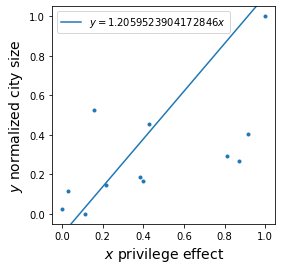

In [48]:
from adjustText import adjust_text

colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(4,4))

i = 0

plt.plot(normprivilegeCommutersRate,normdensity,'.')
    
ax.set_xlabel('$x$ privilege effect',fontsize=14)
ax.set_ylabel('$y$ normalized city size',fontsize=14)


# plt.xlim([-0.02, 0.12])
# plt.ylim([-0.2, 1.2])
m = fitmodel.params[0]
plt.axline(xy1=(0.5, 0.5), slope=m, label=f'$y = %sx$'%m)
plt.legend()
# plt.savefig('img/priviledge effect - public transit.png')

## privilege effect
gap integrated by %% of commuters

In [14]:
def privilegeEffect(privilege_zone,curve1,curve3,df):
    ind = 0
    totalarea = 0
    start = privilege_zone[0]
    end = privilege_zone[1]
    distList = []
    for dist,fd in curve1:
        if dist > start and dist < end:
            gap1 = (curve3[ind][1] - fd)/fd
            gap2 = (curve3[ind+1][1] - curve1[ind+1][1])/curve1[ind+1][1]
            commuter = df.loc[df['distance'].between(curve3[ind][0],curve3[ind+1][0]-1e-99,inclusive=True)]['SE03flow'].sum()
            area = (gap1+gap2)*commuter*0.5
            totalarea += area
            distList += [(ind,dist)]
#             print(dist,totalarea,commuter)
        ind += 1
#     print(distList)
    
    # if the privilege zone is a part of the last distance bin
    if len(distList) < 1:
        gap = (curve3[-1][1] - curve1[-1][1])/curve1[-1][1]
        commuter = df.loc[df['distance'].between(privilege_zone[1],curve3[-1][0],inclusive=True)]['SE03flow'].sum()
        area = gap*commuter*0.5
        totalarea += area
    else:
        # two triangles
        # the first triangle is between the first intersection point and the start of the first bin in privilege zone
        gap = (curve3[distList[0][0]][1] - curve1[distList[0][0]][1])/curve1[distList[0][0]][1]
        commuter = df.loc[df['distance'].between(distList[0][1],curve3[distList[0][0]][0]-1e-99,inclusive=True)]['SE03flow'].sum()
        area = gap*commuter*0.5
        totalarea += area

        # the second triangle is between the first intersection point and the end of the last bin in privilege zone
        # if the end of the last bin in distList is not in the privilege zone
        # the area of the second triangle is supposed to be a negatvie value
        if distList[-1][0]+1 < len(curve1):
            if curve3[distList[-1][0]+1][0] > privilege_zone[1]:
                gap = (curve3[distList[-1][0]+1][1] - curve1[distList[-1][0]+1][1])/curve1[distList[-1][0]+1][1]
                commuter = df.loc[df['distance'].between(distList[-1][1],curve3[distList[-1][0]+1][0],inclusive=True)]['SE03flow'].sum()
                area = gap*commuter*0.5
                totalarea += area
    #             print('end',curve3[distList[-1][0]+1][0],distList[-1][1])
    #             print('gap',curve3[distList[-1][0]+1][1] - curve1[distList[-1][0]+1][1],area)
    #             print(curve3[distList[-1][0]+1][0],totalarea,commuter)
    return totalarea

In [15]:
### privilege effect degree (gap between two curves integrated by %% of privilege commuters in this zone)
### privilege zone is the longest privilege zone

privilegeEffectValue = {}
for city,state, counties in cities:
    if city in citiesList:
        curve1 = list(zip([float(i) for i in Distfd1[city].keys()],Distfd1[city].values()))
        curve3 = list(zip([float(i) for i in Distfd3[city].keys()],Distfd3[city].values()))
        length,privilege_zone = the_longest_privilege_zone(curve1,curve3)
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        totalarea = privilegeEffect(privilege_zone,curve1,curve3,df)
        totalSE03 = df.loc[df['distance'].between(privilege_zone[0],privilege_zone[1])]['SE03flow'].sum()
        print(city,totalarea/totalSE03)
        privilegeEffectValue[city] = totalarea/totalSE03

New York City 0.06590550626413079
Los Angeles 0.71826308794309
Chicago 0.07696948628786406
Houston 0.22830399022798298
Boston 0.24604151828161494
Phoenix 0.15945591300193984
Philadelphia 0.11451083937734091
San Antonio 0.08436785647254111
San Diego 0.1049013395319296
Dallas 0.09927673391080066
San Jose 0.13454987423139037
Austin 0.15261706154660756


In [16]:
import libpysal

In [18]:
# job concentration geary's C
jobconcentration = {}
from esda.geary import Geary
for city,state, counties in cities:
    if city in citiesList:
        
        df = pd.read_parquet(f'data/income_{city}.parquet')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        if afterendpointPercentage > 0:
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        else:
            endPoint = df.distance.max()
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endPoint)]
        df = df.drop_duplicates(subset = ['destination'])
        print('flow data loaded')
        state_network = provider.get_data(state=state, year=2018)
        city_network = state_network.filter_nodes(state_network.nodes.county.isin(counties))
        nodes = city_network.nodes
        print('geo data loaded')
        
        df = nodes.merge(df,right_on='destination',left_on='id')
        
        print('calculating geary C')
        weights = libpysal.weights.Queen.from_dataframe(df)  # generate spatial weights (Queen in this case)
        spatial_auto1 = Geary(df[['SE01jobs']], weights,permutations=0)  # calculate Moran's I
        spatial_auto3 = Geary(df[['SE03jobs']], weights,permutations=0)
        concentration01 = spatial_auto1.C
        concentration03 = spatial_auto3.C
        
        concentration = concentration03
        jobconcentration[city] = concentration
        print(city,concentration)

flow data loaded
geo data loaded
calculating geary C
('WARNING: ', 833, ' is an island (no neighbors)')
('WARNING: ', 1150, ' is an island (no neighbors)')
New York City 0.4750275652348239
flow data loaded
geo data loaded
calculating geary C
Los Angeles 1.1642146766147103
flow data loaded
geo data loaded
calculating geary C
Chicago 1.192442469259796
flow data loaded
geo data loaded
calculating geary C
Houston 1.1209927435014333
flow data loaded
geo data loaded
calculating geary C
Boston 0.7910847390024839
flow data loaded
geo data loaded
calculating geary C
Phoenix 0.845115382400381
flow data loaded
geo data loaded
calculating geary C
Philadelphia 0.8309865824008079
flow data loaded
geo data loaded
calculating geary C
San Antonio 1.0211242766057946
flow data loaded
geo data loaded
calculating geary C
San Diego 1.1576225659787227
flow data loaded
geo data loaded
calculating geary C
Dallas 1.0773740359836348
flow data loaded
geo data loaded
calculating geary C
San Jose 1.0175573837973393

In [19]:
scaler = MinMaxScaler()
normjobconcentration = scaler.fit_transform(np.array(list(jobconcentration.values())).reshape(-1,1))

scaler = MinMaxScaler()
normprivilegeCommutersRate = scaler.fit_transform(np.array(list(privilegeEffectValue.values())).reshape(-1,1))

fitmodel = sm.OLS(normprivilegeCommutersRate,normjobconcentration).fit()
fitmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.363
Model:                            OLS   Adj. R-squared (uncentered):              0.305
Method:                 Least Squares   F-statistic:                              6.275
Date:                Wed, 13 Jul 2022   Prob (F-statistic):                      0.0292
Time:                        14:46:29   Log-Likelihood:                        -0.50525
No. Observations:                  12   AIC:                                      3.011
Df Residuals:                      11   BIC:                                      3.495
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2472      0.099      2.505      0.029       0.030       0.464
==============================================================================
Omnibus:                       21.347   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.490
Skew:                           2.167   Prob(JB):                     0.000159
Kurtosis:                       7.025   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
scaler = MinMaxScaler()
normdensity = scaler.fit_transform((np.array(list(population.values()))/np.array(list(size.values()))).reshape(-1,1))

scaler = MinMaxScaler()
normConcentration = scaler.fit_transform(np.array(list(jobconcentration.values())).reshape(-1,1))

fitmodel = sm.OLS(normdensity,normConcentration).fit()
fitmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.175
Model:                            OLS   Adj. R-squared (uncentered):              0.100
Method:                 Least Squares   F-statistic:                              2.326
Date:                Wed, 29 Jun 2022   Prob (F-statistic):                       0.155
Time:                        21:14:15   Log-Likelihood:                         -1.9085
No. Observations:                  12   AIC:                                      5.817
Df Residuals:                      11   BIC:                                      6.302
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2066      0.135      1.525      0.155      -0.092       0.505
==============================================================================
Omnibus:                       26.605   Durbin-Watson:                   1.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.431
Skew:                           2.534   Prob(JB):                     1.82e-06
Kurtosis:                       8.213   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

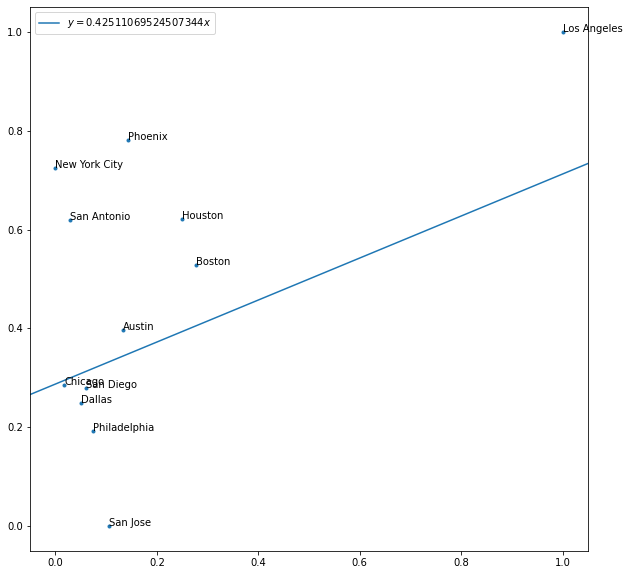

In [690]:
colors = ['#E16BBC','#51A8DD','#B9887D','#F17C67','#FFB11B','#ADA142',
          '#91B493','#268785','#33A6B8','#8F77B5','#b28FCE','#91989F']

fig, ax = plt.subplots(figsize=(10,10))

i = 0

plt.plot(normprivilegeCommutersRate,normjobconcentration,'.')

for i, txt in enumerate(citiesList):
    ax.annotate(txt, (normprivilegeCommutersRate[i], normjobconcentration[i]))    
# ax.set_xlabel('$x$ privilege effect',fontsize=14)
# ax.set_ylabel('$y$ normalized city size',fontsize=14)

m = fitmodel.params[0]
plt.axline(xy1=(0.5, 0.5), slope=m, label=f'$y = %sx$'%m)
plt.legend()
# plt.savefig('img/priviledge effect - public transit.png')

## Monte Carlo simulation

In [33]:
NUM_POINTS = 20

def generate_random_points(shape):
    minx, miny, maxx, maxy = shape.bounds
    xc = (maxx - minx) * np.random.random(NUM_POINTS) + minx
    yc = (maxy - miny) * np.random.random(NUM_POINTS) + miny

    points = gpd.GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
    filtered_points = points.loc[points.within(shape)]
    points_geo = list(zip(filtered_points.y, filtered_points.x))
    return points_geo
    
def get_avg_point_to_point_distance(shape_a, shape_b):
    points_a = generate_random_points(shape_a)
    points_b = generate_random_points(shape_b)
    common_points = min(len(points_a), len(points_b), 1)
    if common_points == 0:
        return None
    
    points_a_c = points_a[0:common_points]
    points_b_c = points_b[0:common_points]
    distance = haversine_vector(points_a_c, points_b_c, Unit.KILOMETERS)
    mean_distance = statistics.mean(distance)
    return mean_distance


SAMPLES = 20000


def get_avg_distance(gdf):
    output = []
    for i in range(SAMPLES):
        sample = gdf.sample(n = 2)

        shape_a = sample.reset_index().loc[0]["geometry"]
        shape_b = sample.reset_index().loc[1]["geometry"]
        id_a = sample.index[0]
        id_b = sample.index[1]
        avg_distance = get_avg_point_to_point_distance(shape_a, shape_b)
        if avg_distance is not None:
            output.append({'from': id_a, 'to': id_b, 'p2p_avg_distance': avg_distance})
    
    pdf = pd.DataFrame(output)
    return pdf

In [67]:
output = {}
for city, state, conties in cities:
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    training_set = build_training_set(city_network, 'S000')
    nodes = city_network.nodes
    avg_distance = get_avg_distance(nodes)
    
    merged = pd.merge(training_set, avg_distance,  how='inner', left_on=['origin','destination'], right_on = ['from','to'])
    merged_filtered = merged
    merged_filtered['delta'] = np.abs(merged_filtered.distance - merged_filtered.p2p_avg_distance)
    quantiles = merged_filtered.delta.quantile([.5, .6, .7, .8, .9, 0.95, 0.99])
    output[city] = quantiles.to_dict()
    error = merged_filtered.delta.mean() 
    print(f"{city}: {error}")

New York City: 0.23318465336358488
Los Angeles: 0.5880542251098596
Chicago: 0.47264545956451637
Houston: 0.8544507944813855
Boston: 0.7216409787770274
Phoenix: 1.0696908912977126
Philadelphia: 0.35620353722320486
San Antonio: 0.9753960859438853
San Diego: 0.9532767780401463
Dallas: 0.729267064123792
San Jose: 0.7819044087441388
Austin: 1.136174461579971
